# Determining the Likelihood of Flight Occupancy

## Summary

Through the use of the logistic regression, which I know to work well on sparse data matrices (as this in some way is based on how I chose to associated attributes with the unit of analysis), I tried to determine the probability of flight occupancy. Data provided for training was of flights from June 2019 through mid-December 2019, and the flights with unknown occupancy status were those that happened from mid-December to the end of 2019.

I first made some preliminary views so that I could see if there was class imbalance as well as if what needed to be predicted was something that could vary with the time of the year just given the way that travel and vacationing happens in the U.S.: it is time-dependent and has peaks and dips at some of the same times every year. Both ended up being no in the end. The initial data set was rather bare, only really having the most basic details of every flight so some features needed to be created off the departure and arrival datetime values, and in particular, I created a variable that represented flight time in hours given that all the flights ranged from a little under an hour to a little over four. I then binned this variable since looking at decimal values would make the variable too fine for this rather small data set. 

Other feature engineering that could have been done off the time variables would be to have calculated day of week (Sunday-Saturday) as well as time of day when the flight took place (morning, afternoon, evening, etc.) since occupancy probably varies with those other time-based variables, though there didn't seem to be a clear weekly pattern based on the daily line chart. 

In the end, after running the logreg, we yielded an ROC AUC of .71, which is acceptable since it's not abysmally low but also doesn't suggest that the model is overfitted. Given what I know about WheelsUp, it's likely that competitors are operating in a similar way, using local airports and all, and so I used the L2 penalty so as to not completely eliminate variables with little frequency in the flight records. When applying the output to the out-of-sample prediction set, the results of both classes (occupied and not occupied) were about the same as in the training set. In the future, I would use grid search and cross-validation in an automated way to ensure that this one run of the model is accurate, though I at least attempted a manual version of grid search this time.

## Initial Steps: importing libraries, loading data, observing attributes (EDA, feature eng.)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# from sklearn.model_selection import GridSearchCV

In [2]:
training = pd.read_excel("DATASET.xlsx", sheet_name = 'training')
prediction = pd.read_excel("DATASET.xlsx", sheet_name = 'prediction')

In [3]:
display(training.head(3))
training.dtypes

,ID,AIRCRAFT,FROMAIRPORT,TOAIRPORT,DEPARTURETIMEUTC,ARRTIMEUTC,OCCUPIED_FLAG
0,1,NRG001,KTTN,KSPI,2019/06/02 11:17,2019/06/02 13:29,0
1,2,NRG001,KSPI,KAPF,2019/06/02 14:50,2019/06/02 17:15,1
2,3,NRG001,KAPF,KFDK,2019/06/02 18:52,2019/06/02 21:36,1


ID                   int64
AIRCRAFT            object
FROMAIRPORT         object
TOAIRPORT           object
DEPARTURETIMEUTC    object
ARRTIMEUTC          object
OCCUPIED_FLAG        int64
dtype: object

<AxesSubplot:xlabel='OCCUPIED_FLAG'>

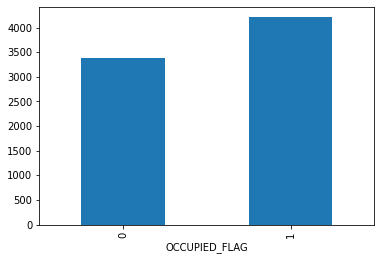

In [4]:
# to see class distribution
training.groupby('OCCUPIED_FLAG').size().plot.bar()

In [5]:
# datetime updates and new feature creation
def date_transformations(df):
    df['DEPARTURETIMEUTC'] = pd.to_datetime(df['DEPARTURETIMEUTC'], format='%Y/%m/%d %H:%M')
    df['ARRTIMEUTC'] = pd.to_datetime(df['ARRTIMEUTC'], format='%Y/%m/%d %H:%M')
    df["AirTime"] = (df['ARRTIMEUTC'] - df['DEPARTURETIMEUTC']).astype('timedelta64[m]')/60

In [6]:
date_transformations(training)
date_transformations(prediction)
prediction.dtypes

ID                           int64
AIRCRAFT                    object
FROMAIRPORT                 object
TOAIRPORT                   object
DEPARTURETIMEUTC    datetime64[ns]
ARRTIMEUTC          datetime64[ns]
AirTime                    float64
dtype: object

In [7]:
training["AirTime"].head(8).to_list()

[2.2,
 2.4166666666666665,
 2.7333333333333334,
 1.2,
 2.566666666666667,
 2.15,
 2.7,
 2.0]

In [8]:
# summary statistics of the constructed variable, flight time in hours
training["AirTime"].describe()

count    7590.000000
mean        1.481682
std         0.645475
min         0.200000
25%         0.983333
50%         1.400000
75%         1.900000
max         4.100000
Name: AirTime, dtype: float64

<AxesSubplot:ylabel='Frequency'>

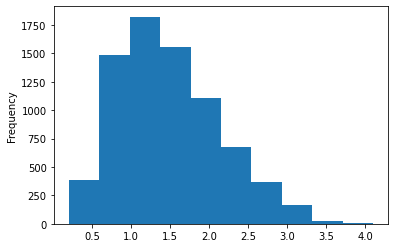

In [9]:
# seeing the distribution of flight times across all flights in the sample and not in the sample 
# the second one for a similar reason to that of seeing aircraft types above
training["AirTime"].plot(kind='hist')
# prediction["AirTime"].plot(kind='hist')

In [10]:
# binning flight time based on actual values rather than the range of the data set which can change over time
training["AirTime_bin"] = np.digitize(training["AirTime"],[.5,1.0,1.5,2,2.5,3,3.5,4.0,4.5])
prediction["AirTime_bin"] = np.digitize(prediction["AirTime"],[.5,1.0,1.5,2,2.5,3,3.5,4.0,4.5])

In [11]:
# observing the result of new interval creation
training["AirTime_bin"]

0       4
1       4
2       5
3       2
4       5
       ..
7585    2
7586    3
7587    2
7588    3
7589    5
Name: AirTime_bin, Length: 7590, dtype: int64

<AxesSubplot:xlabel='DEPARTURETIMEUTC'>

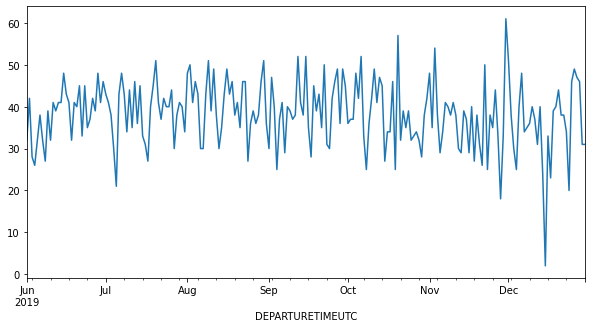

In [12]:
# trying to see patterns of daily flights over the time frame of the data set
training_counts = training.groupby(training["DEPARTURETIMEUTC"].dt.to_period('D')).size()
prediction_counts = prediction.groupby(prediction["DEPARTURETIMEUTC"].dt.to_period('D')).size()

daily_flights = pd.concat([training_counts,prediction_counts])
daily_flights.plot.line(figsize=(10,5))

In [13]:
# calculating the number of flights that were actually occupied daily
training_occup = training.groupby(training["DEPARTURETIMEUTC"].dt.to_period('D')).agg({'ID':'count',
                                                                                       'OCCUPIED_FLAG':'sum'})
training_occup["OccupRate"] = training_occup['OCCUPIED_FLAG'] / training_occup['ID']
training_occup

,ID,OCCUPIED_FLAG,OccupRate
DEPARTURETIMEUTC,,,
2019-06-01,32,17,0.531250
2019-06-02,42,23,0.547619
2019-06-03,28,14,0.500000
2019-06-04,26,19,0.730769
2019-06-05,32,16,0.500000
...,...,...,...
2019-12-10,40,22,0.550000
2019-12-11,37,23,0.621622
2019-12-12,31,18,0.580645


<AxesSubplot:xlabel='DEPARTURETIMEUTC'>

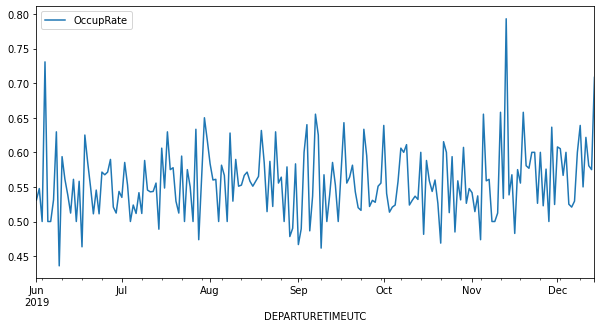

In [14]:
# occupancy rate doesn't seem to vary throughout the (second half of the) year
training_occup[["OccupRate"]].plot.line(figsize=(10,5))

In [15]:
# to see if the same set of aircraft types exist in both data sets; if not, would be a bad set of variables to use
display(training.AIRCRAFT.unique())
display(prediction.AIRCRAFT.unique())

array(['NRG001', 'NRG002', 'NRG003', 'NRG004', 'NRG005', 'NRG006',
       'NRG007', 'NRG008', 'NRG009', 'NRG010', 'NRG011', 'NRG012',
       'NRG013', 'NRG014', 'NRG015', 'NRG016', 'NRG017', 'NRG018',
       'NRG019', 'NRG020', 'NRG021', 'NRG022', 'NRG023', 'NRG024',
       'NRG025', 'NRG026', 'NRG027'], dtype=object)

array(['NRG001', 'NRG002', 'NRG003', 'NRG004', 'NRG005', 'NRG006',
       'NRG007', 'NRG008', 'NRG009', 'NRG010', 'NRG011', 'NRG012',
       'NRG013', 'NRG014', 'NRG015', 'NRG016', 'NRG017', 'NRG018',
       'NRG020', 'NRG021', 'NRG022', 'NRG023', 'NRG024', 'NRG025'],
      dtype=object)

## Transformation of In-Sample Data for Running the Model

In [16]:
# transforming variables to include the attribute name and attribute value
def variable_transformations(df):
    df['AIRCRAFT'] = 'AIRCRAFT | ' + df['AIRCRAFT'].astype(str)
    df['FROMAIRPORT'] = 'FROMAIR | ' + df['FROMAIRPORT'].astype(str)
    df['TOAIRPORT'] = 'TOAIR | ' + df['TOAIRPORT'].astype(str)
    df['AirTime_bin'] = 'AIRTIME_BIN | ' + df['AirTime_bin'].astype(str)

In [17]:
variable_transformations(training)
variable_transformations(prediction)

display(training.head())
display(prediction.head())

,ID,AIRCRAFT,FROMAIRPORT,TOAIRPORT,DEPARTURETIMEUTC,ARRTIMEUTC,OCCUPIED_FLAG,AirTime,AirTime_bin
0,1,AIRCRAFT | NRG001,FROMAIR | KTTN,TOAIR | KSPI,2019-06-02 11:17:00,2019-06-02 13:29:00,0,2.200000,AIRTIME_BIN | 4
1,2,AIRCRAFT | NRG001,FROMAIR | KSPI,TOAIR | KAPF,2019-06-02 14:50:00,2019-06-02 17:15:00,1,2.416667,AIRTIME_BIN | 4
2,3,AIRCRAFT | NRG001,FROMAIR | KAPF,TOAIR | KFDK,2019-06-02 18:52:00,2019-06-02 21:36:00,1,2.733333,AIRTIME_BIN | 5
3,4,AIRCRAFT | NRG001,FROMAIR | KFDK,TOAIR | KMVY,2019-06-03 11:48:00,2019-06-03 13:00:00,0,1.200000,AIRTIME_BIN | 2
4,5,AIRCRAFT | NRG001,FROMAIR | KMVY,TOAIR | KSDF,2019-06-03 13:46:00,2019-06-03 16:20:00,1,2.566667,AIRTIME_BIN | 5


,ID,AIRCRAFT,FROMAIRPORT,TOAIRPORT,DEPARTURETIMEUTC,ARRTIMEUTC,AirTime,AirTime_bin
0,1,AIRCRAFT | NRG001,FROMAIR | KPSM,TOAIR | KTTN,2019-12-15 23:21:00,2019-12-16 00:39:00,1.300000,AIRTIME_BIN | 2
1,2,AIRCRAFT | NRG001,FROMAIR | KTTN,TOAIR | KBTV,2019-12-16 17:43:00,2019-12-16 18:51:00,1.133333,AIRTIME_BIN | 2
2,3,AIRCRAFT | NRG001,FROMAIR | KBTV,TOAIR | KPWM,2019-12-16 21:41:00,2019-12-16 22:23:00,0.700000,AIRTIME_BIN | 1
3,4,AIRCRAFT | NRG001,FROMAIR | KPWM,TOAIR | KBTV,2019-12-17 01:59:00,2019-12-17 02:42:00,0.716667,AIRTIME_BIN | 1
4,5,AIRCRAFT | NRG001,FROMAIR | KBTV,TOAIR | KTEB,2019-12-17 19:45:00,2019-12-17 21:01:00,1.266667,AIRTIME_BIN | 2


In [18]:
# df.set_index(['ID','OCCUPIED_FLAG'], inplace = True)
# train_data = pd.concat([df['AIRCRAFT'],df['FROMAIRPORT'],df['TOAIRPORT'],df['AirTime_bin']])\
# .rename(columns={"0":"att_nv"}).reset_index()

# unpivoting the in sample dataframe to have ID, class (OCCUPIED_FLAG), and attribute name + value
columns = ['AIRCRAFT','FROMAIRPORT','TOAIRPORT','AirTime_bin']
frames=[training[['ID','OCCUPIED_FLAG',column]].rename(columns={column:'att_nv'}) for column in columns]
in_sample=pd.concat(frames)

In [19]:
in_sample

,ID,OCCUPIED_FLAG,att_nv
0,1,0,AIRCRAFT | NRG001
1,2,1,AIRCRAFT | NRG001
2,3,1,AIRCRAFT | NRG001
3,4,0,AIRCRAFT | NRG001
4,5,1,AIRCRAFT | NRG001
...,...,...,...
7585,7586,1,AIRTIME_BIN | 2
7586,7587,0,AIRTIME_BIN | 3
7587,7588,1,AIRTIME_BIN | 2
7588,7589,1,AIRTIME_BIN | 3


In [20]:
# unpivoting the out of sample dataframe to have ID, class (OCCUPIED_FLAG), and attribute name + value
frames=[prediction[['ID',column]].rename(columns={column:'att_nv'}) for column in columns]
out_sample=pd.concat(frames)

In [21]:
out_sample.head()

,ID,att_nv
0,1,AIRCRAFT | NRG001
1,2,AIRCRAFT | NRG001
2,3,AIRCRAFT | NRG001
3,4,AIRCRAFT | NRG001
4,5,AIRCRAFT | NRG001


In [22]:
in_sample.loc[(in_sample['ID'] == 2)]

,ID,OCCUPIED_FLAG,att_nv
1,2,1,AIRCRAFT | NRG001
1,2,1,FROMAIR | KSPI
1,2,1,TOAIR | KAPF
1,2,1,AIRTIME_BIN | 4


In [23]:
# defining a function to create a specifically formatted dictionary out of the in sample data frame
# for each ID, all associated attribute name + value dummy pairs will be given a value of 1
def taxonomy_dict(data):
    taxonomy_dict = {}
    for index, row in data.iterrows():
        row_list = row.values.tolist()
        ID = str(row_list[0])
        OCCUPIED_FLAG = row_list[1]
        t_code = row_list[2]
        if ID not in taxonomy_dict:
            taxonomy_dict[ID] = [int(OCCUPIED_FLAG),{}]
        taxonomy_dict[ID][1][t_code]=1
    return taxonomy_dict

In [24]:
model_data = taxonomy_dict(in_sample)

## Running the LogReg Classifer on the Prepared In-Sample Data

In [25]:
# creating the training and testing sets within the in sample data
feature_learner = DictVectorizer()
X = feature_learner.fit_transform(x[1] for x in model_data.values())
y = [x[0] for x in model_data.values()]
# X_oop = feature_learner.transform(x[1] for x in test_data.values())
# y_oop = [x[0] for x in test_data.values()]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.4,random_state=1)

In [26]:
# fitting logistic regression to the in sample test data
# using L2 because 
# some manual grid search by changing the value of C to see if regularization strength has a major impact on ROC AUC
logreg=LogisticRegression(penalty='l2',C=.0009,class_weight='balanced',fit_intercept=True)
logreg.fit(X_train,y_train)
y_predicted = logreg.predict(X_test)
y_prob = logreg.predict_proba(X_test)

print('\tROC AUC score: '+str(round(roc_auc_score(y_test,y_predicted),2)))

	ROC AUC score: 0.71


## Applying Model Output on Out-of-Sample Data

In [27]:
# getting coefficient values of the attribute name+value pairs (the dummies in our model)
coefficients = logreg.coef_[0]
feature_names = feature_learner.get_feature_names()
coeffs = pd.DataFrame(zip(coefficients,feature_names),columns=['coefficient','attribute'])
coeffs

,coefficient,attribute
0,-0.002499,AIRCRAFT | NRG001
1,0.003343,AIRCRAFT | NRG002
2,-0.006064,AIRCRAFT | NRG003
3,0.002489,AIRCRAFT | NRG004
4,0.006296,AIRCRAFT | NRG005
...,...,...
1011,-0.000497,TOAIR | KZZV
1012,0.000016,TOAIR | MYAM
1013,-0.000538,TOAIR | MYAT
1014,0.000388,TOAIR | MYEH


In [28]:
# logreg.coef_
print(logreg.coef_[0])

# logreg.intercept_
print(logreg.intercept_[0])

[-0.0024985   0.00334309 -0.00606384 ... -0.00053812  0.00038768
 -0.00011477]
0.027375307061451075


In [29]:
# applying the coefficient values to the out of sample IDs
inputs_outputs = pd.merge(out_sample,coeffs,how='left',left_on=["att_nv"],right_on=["attribute"])
inputs_outputs

,ID,att_nv,coefficient,attribute
0,1,AIRCRAFT | NRG001,-0.002499,AIRCRAFT | NRG001
1,2,AIRCRAFT | NRG001,-0.002499,AIRCRAFT | NRG001
2,3,AIRCRAFT | NRG001,-0.002499,AIRCRAFT | NRG001
3,4,AIRCRAFT | NRG001,-0.002499,AIRCRAFT | NRG001
4,5,AIRCRAFT | NRG001,-0.002499,AIRCRAFT | NRG001
...,...,...,...,...
2239,557,AIRTIME_BIN | 3,0.124737,AIRTIME_BIN | 3
2240,558,AIRTIME_BIN | 0,-0.057632,AIRTIME_BIN | 0
2241,559,AIRTIME_BIN | 2,-0.038494,AIRTIME_BIN | 2
2242,560,AIRTIME_BIN | 2,-0.038494,AIRTIME_BIN | 2


In [30]:
# combining the coefficient values for each ID to get a single calculated score (and adding the intercept)
scored = inputs_outputs.groupby(["ID"],as_index=False).agg({'coefficient':'sum'})
scored["coefficient"] += logreg.intercept_[0]

In [31]:
scored

,ID,coefficient
0,1,-0.013252
1,2,-0.024248
2,3,-0.227989
3,4,-0.232406
4,5,-0.002456
...,...,...
556,557,0.150329
557,558,-0.031916
558,559,-0.014547
559,560,-0.014200


In [32]:
# calculating a probability from the resultant score and assigning prob >= .5 to the occupied class
scored["prob"] = np.exp(scored['coefficient'])/(np.exp(scored['coefficient']) + 1)
scored['OCCUPIED_FLAG'] = np.where(scored["prob"]>=0.5,1,0)
scored

,ID,coefficient,prob,OCCUPIED_FLAG
0,1,-0.013252,0.496687,0
1,2,-0.024248,0.493938,0
2,3,-0.227989,0.443248,0
3,4,-0.232406,0.442159,0
4,5,-0.002456,0.499386,0
...,...,...,...,...
556,557,0.150329,0.537512,1
557,558,-0.031916,0.492022,0
558,559,-0.014547,0.496363,0
559,560,-0.014200,0.496450,0


## Seeing the Results of Applying Model Outputs to Out-of-Sample Data

<AxesSubplot:ylabel='Frequency'>

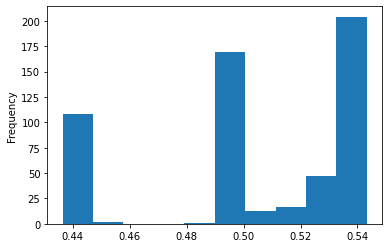

In [33]:
# seeing probability distribution in the out of sample data
scored["prob"].plot(kind='hist')

<AxesSubplot:xlabel='OCCUPIED_FLAG'>

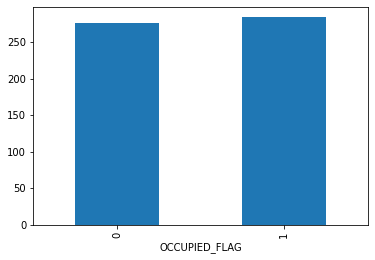

In [34]:
# seeing resulting class distribution in the out of sample data
# scored["OCCUPIED_FLAG"] = scored["OCCUPIED_FLAG"].apply(str)
scored.groupby('OCCUPIED_FLAG').size().plot.bar()

In [35]:
# outputing results to a CSV
# scored[['ID','OCCUPIED_FLAG']].to_csv('prediction.csv',index=False)